# Problem 1


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd 
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#disabling eager execution 
tf.compat.v1.disable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)

Num GPUs Available:  1
Tensorflow version:  2.4.0


In [7]:
#from art.utils import load_mnist
#from art.estimators.classification import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
#from art.attacks.evasion import FastGradientMethod
#from art.attacks.evasion import CarliniL2Method
from utils import preprocess_mnist
import matplotlib.pyplot as plt 

As per recommendation on piazza: defining the same architecture as original trained model but with linear activation instead of softmax 

In [8]:
#define
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="linear"))
#compile: same as original 
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])



In [9]:
#load trained weights from original model
model.load_weights(r'mnist_model_weights.h5')

In [10]:
#save full model for use with Carlini Attacks: no softmax layer only linear with trained weights
model.save(r'model')

INFO:tensorflow:Assets written to: model\assets


In [5]:
#apply ART wrapper: min and max pixel value were 0 and 1 when loaded in using load_mnist from art.utils
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0), use_logits=True)

Load and preprocessed  benign test samples

In [6]:
x_attack_test = np.load(r'x_attack_test.npy')
y_attack_test = np.load(r'y_attack_test.npy')


In [7]:
#define some constants
num_test_samples = x_attack_test.shape[0]
#define target class 
t = 7

In [8]:
num_test_samples

100

In [9]:
#print out accuracy on benign samples 
predictions = classifier.predict(x_attack_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_attack_test, axis=1)) / num_test_samples
print(f"Accuracy on benign test examples: {accuracy*100}%")

C:\Users\apra\Anaconda3\envs\cy_hw2\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on benign test examples: 100.0%


In [10]:
#print number of target class predictions on benign samples (should be close to 0)
num_targ_class = np.sum(np.argmax(predictions, axis=1) == t) / num_test_samples

In [11]:
print(f"Percentage predicted to be target class ({t}) on benign test examples: {num_targ_class*100}%")

Percentage predicted to be target class (7) on benign test examples: 0.0%


In [12]:
x_attack_test.shape

(100, 28, 28, 1)

In [13]:

y_attack_test.shape

(100, 10)

## 1a: FSGM attack : we use the softmax model

### TARGETTED ATTACKS

In [14]:
target_class_vector = t*np.ones(num_test_samples)

In [15]:
epsilons = [0.1,0.2,0.3,0.4,0.5]

In [16]:
softmax_model = keras.models.load_model(r'softmax_model')
softmax_classifier = KerasClassifier(model=softmax_model, clip_values=(0.0, 1.0), use_logits=True)

In [17]:
#store best attacks in a list of dictionaries
targeted_fsgm_best_attacks = []
for e in epsilons:
    fsgm_targeted = FastGradientMethod(estimator=softmax_classifier, eps=e,targeted=True)
    #norm is l_infinity by default
    x_test_fsgm_targeted = fsgm_targeted.generate(x=x_attack_test,y=target_class_vector)
    fsgm_targeted_predictions = softmax_classifier.predict(x_test_fsgm_targeted)
    #in the targeted case, attack success rate is simply the percent of test samples classified
    #as target class (since this class is not present in the test set)
    success_mask = np.argmax(fsgm_targeted_predictions, axis=1) == t
    attack_success_rate = np.sum(success_mask) / num_test_samples
    print(f"Attack Success Rate on targeted fsgm attack examples for epsilon = {e} : {round(attack_success_rate*100,2)}%")
    
    
    
    #identify and store adversarial inputs for each epsilon with highest target classification confidence
    confidences = pd.Series(fsgm_targeted_predictions[:,7],index=range(num_test_samples))
    
    #get highest successful attacks with highest confidence
    conf_idx = pd.Series.idxmax(confidences[success_mask])
    
    best_attacks = {'e':e, 'original_image':x_attack_test[conf_idx], 
                    'attack_image':x_test_fsgm_targeted[conf_idx], 
                    'test_idx' : conf_idx,
                    'perturbation' : (x_attack_test[conf_idx] - x_test_fsgm_targeted[conf_idx]) }
    targeted_fsgm_best_attacks.append(best_attacks)
    

Attack Success Rate on targeted fsgm attack examples for epsilon = 0.1 : 8.0%
Attack Success Rate on targeted fsgm attack examples for epsilon = 0.2 : 14.0%
Attack Success Rate on targeted fsgm attack examples for epsilon = 0.3 : 24.0%
Attack Success Rate on targeted fsgm attack examples for epsilon = 0.4 : 27.0%
Attack Success Rate on targeted fsgm attack examples for epsilon = 0.5 : 26.0%


### UNTARGETTED ATTACKS





In [18]:
for e in epsilons:
    fsgm_untargeted = FastGradientMethod(estimator=softmax_classifier, eps=e)
    #norm is l_infinity by default
    x_test_fsgm_untargeted = fsgm_untargeted.generate(x=x_attack_test)
    predictions = softmax_classifier.predict(x_test_fsgm_untargeted)
    accuracy_mask = np.argmax(predictions, axis=1) == np.argmax(y_attack_test, axis=1)
    
    #in untargeted case, attack success rate is the DROP in accuracy i.e, benign_accuracy-adversarial_accuracy
    #this accurately tells us how many previously correctly classified samples were misclassified by the attack
    attack_success_rate = accuracy - np.sum(accuracy_mask) / num_test_samples
    print(f"Attack Success Rate on untargeted fsgm attack examples for epsilon = {e} : {round(attack_success_rate*100,2)}%")
    

Attack Success Rate on untargeted fsgm attack examples for epsilon = 0.1 : 34.0%
Attack Success Rate on untargeted fsgm attack examples for epsilon = 0.2 : 53.0%
Attack Success Rate on untargeted fsgm attack examples for epsilon = 0.3 : 63.0%
Attack Success Rate on untargeted fsgm attack examples for epsilon = 0.4 : 69.0%
Attack Success Rate on untargeted fsgm attack examples for epsilon = 0.5 : 75.0%


## 1b Targeted Carlini Wagner in L2

In [48]:
constants = [0.01,0.05,0.1,0.5]


In [60]:
#store attack metrics for various c's in a list of dictionaries 
l2_attack_metrics = []
for c in constants:
    carlini = CarliniL2Method(classifier=classifier,targeted=True,initial_const=c,batch_size=32)
    carlini_attacks = carlini.generate(x_attack_test,target_class_vector)
    
    #predictions
    carlini_predict = model.predict(carlini_attacks)
    
    #calculate success rate
    success_mask = np.argmax(carlini_predict, axis=1) == t
    attack_success_rate = sum(success_mask)/num_test_samples
    
    #calculate l2 norm 
    l2dist = np.sqrt(np.sum(np.square(x_attack_test - carlini_attacks).reshape(num_test_samples, -1), axis=1))
    #create series out of l2 dist to pull out min,max,median  
    l2dist = pd.Series(l2dist,index=range(num_test_samples))
    
    #Report attack success rate and avg l2 norm 
    print(f"Attack Success Rate on targeted Carlini Wagner attack examples for c = {c} : {round(attack_success_rate*100,2)}%")
    print(f"Avg L2 Norm on targeted Carlini Wagner attack examples for c = {c} : {round(l2dist.mean(),2)}")
    
    min_l2_idx = pd.Series.idxmin(l2dist[success_mask])
    max_l2_idx = pd.Series.idxmax(l2dist[success_mask])
    median_l2_idx = int(l2dist[success_mask].sort_values(ignore_index=False).reset_index().iloc[sum(success_mask)//2]['index'])
    
    #append the l2 metrics
    l2_attack_metrics.append(
    { 
        'c':c,
        'min_l2_idx':min_l2_idx,
        'max_l2_idx':max_l2_idx,
        'median_l2_idx':median_l2_idx,
        
        'min_l2':l2dist[min_l2_idx],
        'max_l2':l2dist[max_l2_idx],
        'median_l2':l2dist[median_l2_idx],
        
        'original_image_min_l2':x_attack_test[min_l2_idx],
        'original_image_max_l2':x_attack_test[max_l2_idx],
        'original_image_median_l2':x_attack_test[median_l2_idx],
        
        'attack_image_min_l2':carlini_attacks[min_l2_idx],
        'attack_image_max_l2':carlini_attacks[max_l2_idx],
        'attack_image_median_l2':carlini_attacks[median_l2_idx],
        
        'perturbation_min_l2':x_attack_test[min_l2_idx]- carlini_attacks[min_l2_idx],
        'perturbation_max_l2':x_attack_test[max_l2_idx] - carlini_attacks[max_l2_idx],
        'perturbation_median_l2':x_attack_test[median_l2_idx] - carlini_attacks[median_l2_idx]
        
        
        
        
    })

C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Attack Success Rate on targeted Carlini Wagner attack examples for c = 0.01 : 52.0%
Avg L2 Norm on targeted Carlini Wagner attack examples for c = 0.01 : 1.61


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Attack Success Rate on targeted Carlini Wagner attack examples for c = 0.05 : 75.0%
Avg L2 Norm on targeted Carlini Wagner attack examples for c = 0.05 : 2.76


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Attack Success Rate on targeted Carlini Wagner attack examples for c = 0.1 : 77.0%
Avg L2 Norm on targeted Carlini Wagner attack examples for c = 0.1 : 2.87


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Attack Success Rate on targeted Carlini Wagner attack examples for c = 0.5 : 85.0%
Avg L2 Norm on targeted Carlini Wagner attack examples for c = 0.5 : 3.36


# WRITE OBSERVATIONS HERE !!!

## 1c Vizualizations

### (Successful) Adversarial samples with highest confidence for targeted FSGM

We extracted this information in our attack loop

==========EPSILON = 0.1==============


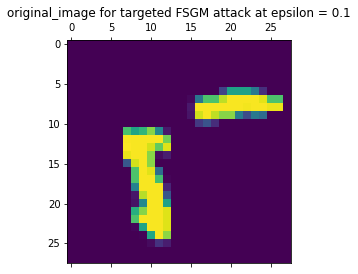

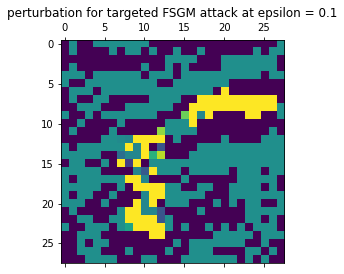

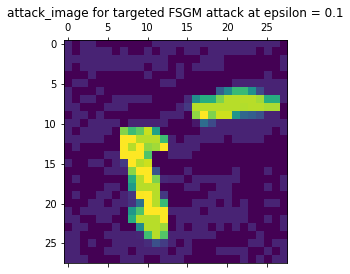


==========EPSILON = 0.2==============


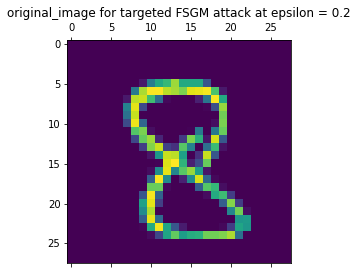

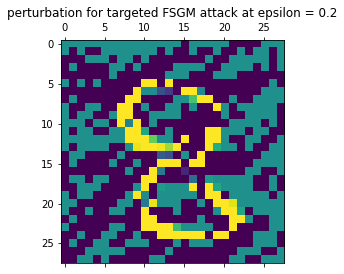

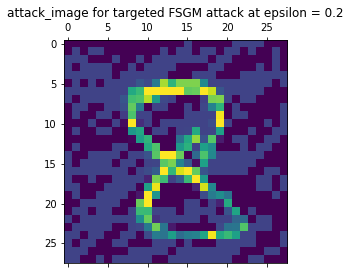


==========EPSILON = 0.3==============


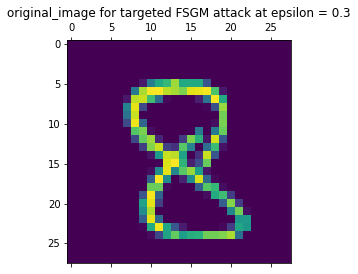

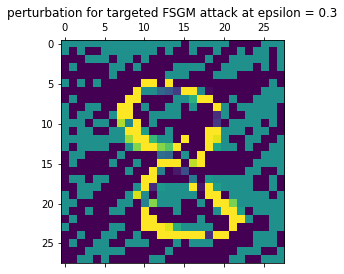

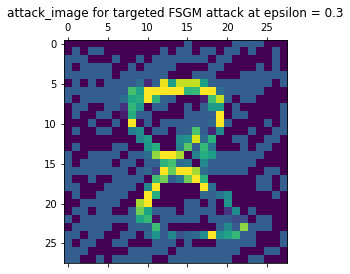


==========EPSILON = 0.4==============


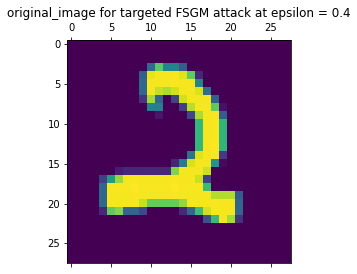

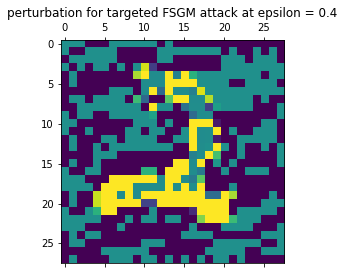

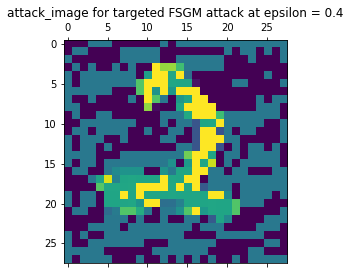


==========EPSILON = 0.5==============


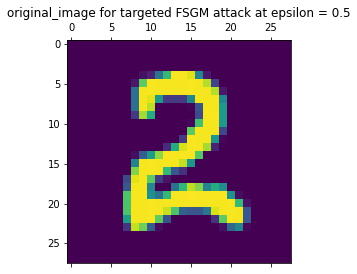

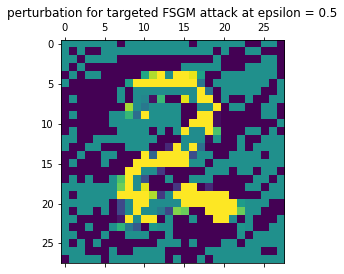

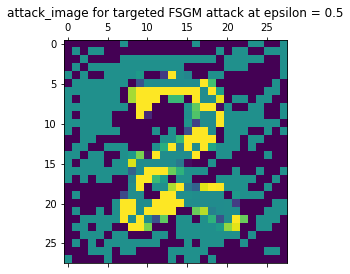

In [54]:
for e_idx,e in enumerate(epsilons):
    print(f"==========EPSILON = {e}==============")
    viz_type = "original_image"
    plt.matshow(targeted_fsgm_best_attacks[e_idx][viz_type])
    plt.title(f"{viz_type} for targeted FSGM attack at epsilon = {epsilons[e_idx]}")
    plt.show()
    viz_type = "perturbation"
    plt.matshow(targeted_fsgm_best_attacks[e_idx][viz_type])
    plt.title(f"{viz_type} for targeted FSGM attack at epsilon = {epsilons[e_idx]}")
    plt.show()
    viz_type = "attack_image"
    plt.matshow(targeted_fsgm_best_attacks[e_idx][viz_type])
    plt.title(f"{viz_type} for targeted FSGM attack at epsilon = {epsilons[e_idx]}")
    plt.show()
    print()

### Min,Max and Median l2 distance images for various values of c: Successful Carlini Wagner attacks

In [56]:
l2_attack_metrics_df = pd.DataFrame(l2_attack_metrics)

In [58]:
l2_attack_metrics_df[['c','min_l2_idx','min_l2','max_l2_idx','max_l2','median_l2_idx','median_l2',]]

,c,min_l2_idx,min_l2,max_l2_idx,max_l2,median_l2_idx,median_l2
0,0.01,67,0.968477,18,6.401949,75,2.925302
1,0.05,74,1.061839,32,7.655855,15,3.565248
2,0.10,74,1.061839,32,7.655855,12,3.681896
3,0.50,74,0.953690,6,8.587667,89,3.597278


### C = 0.01 ###

===========MIN L2 ================


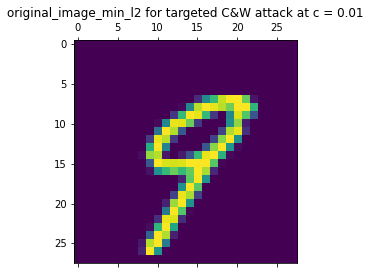

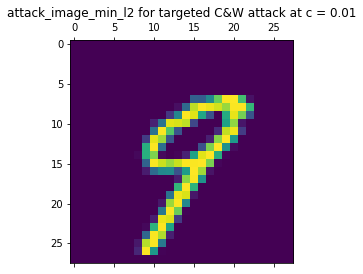

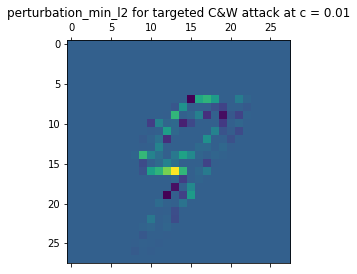

===========MAX L2 ================


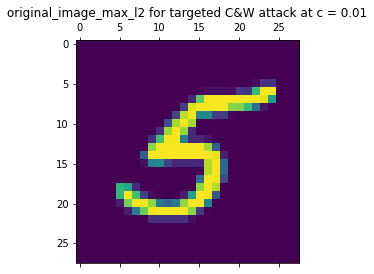

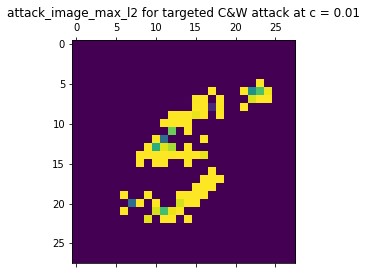

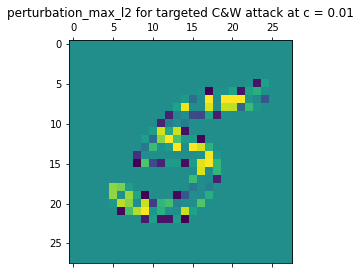

===========MEDIAN L2 ================


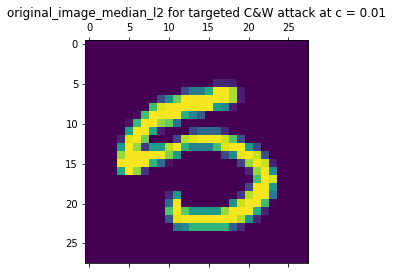

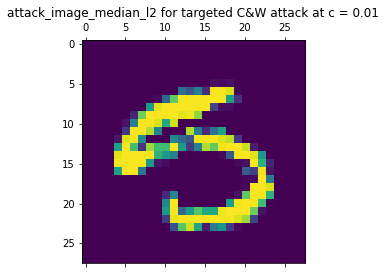

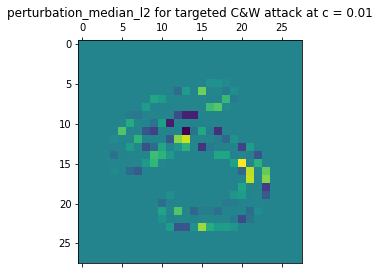

In [61]:
c_i,c = 0,0.01
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

### C = 0.05 ###

===========MIN L2 ================


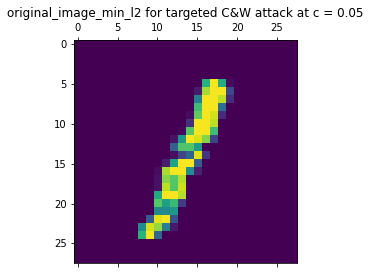

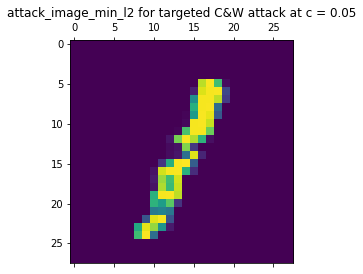

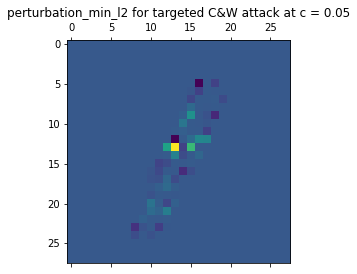

===========MAX L2 ================


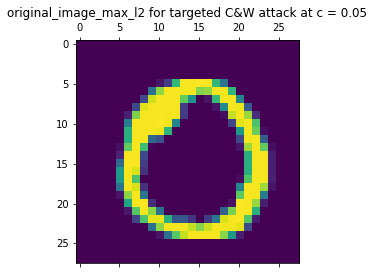

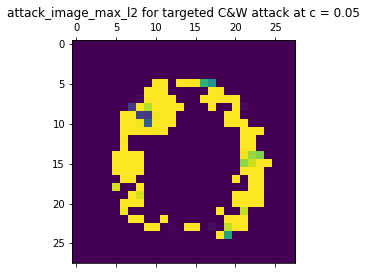

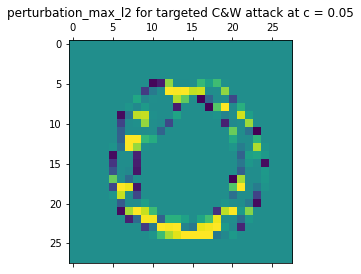

===========MEDIAN L2 ================


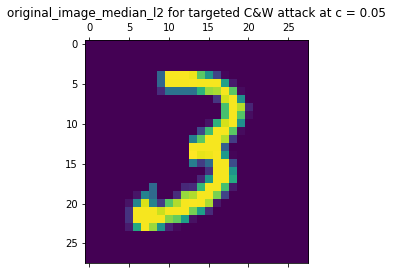

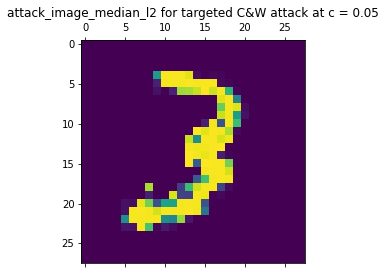

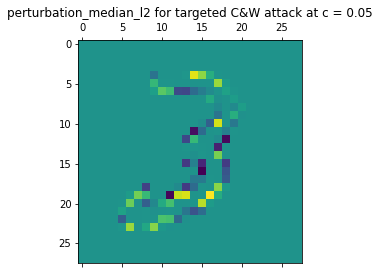

In [62]:
c_i,c = 1,0.05
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

### C = 0.1 ###

===========MIN L2 ================


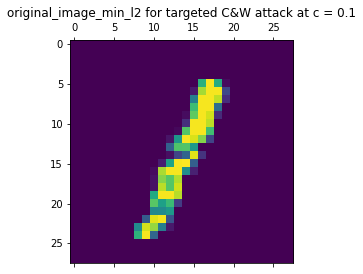

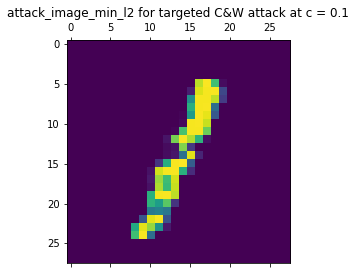

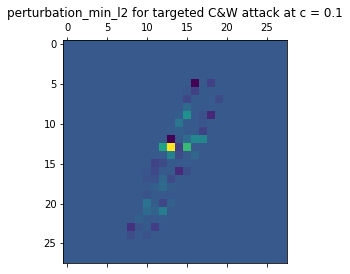

===========MAX L2 ================


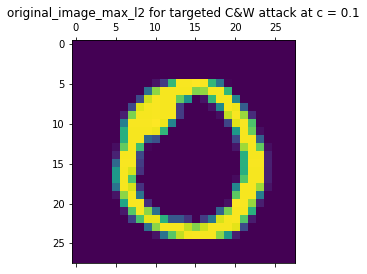

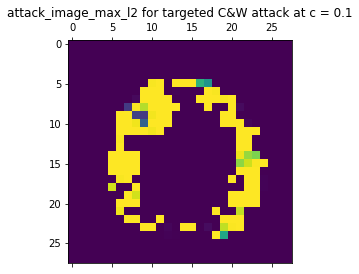

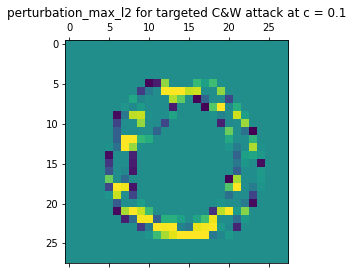

===========MEDIAN L2 ================


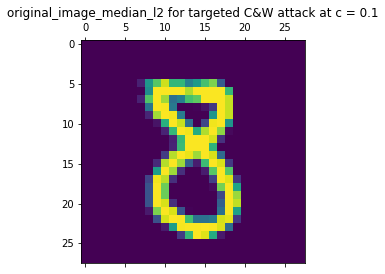

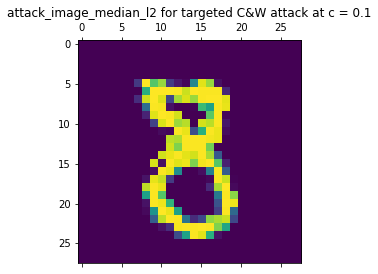

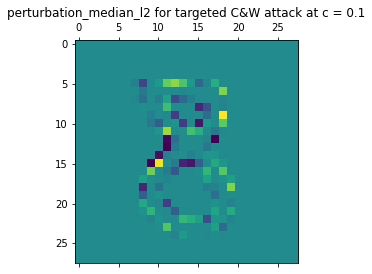

In [63]:
c_i,c = 2,0.1
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

### C = 0.3 ###

===========MIN L2 ================


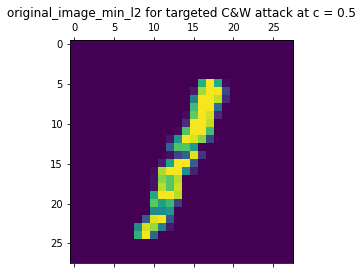

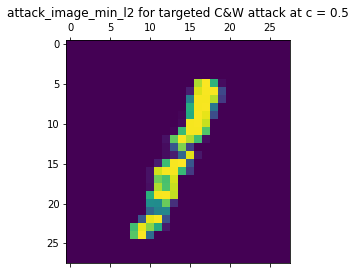

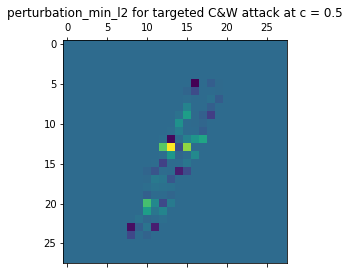

===========MAX L2 ================


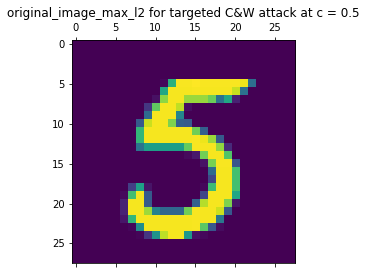

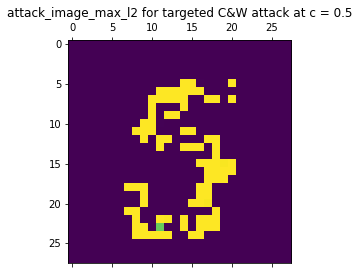

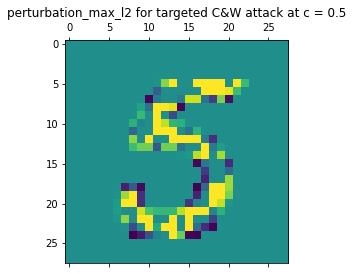

===========MEDIAN L2 ================


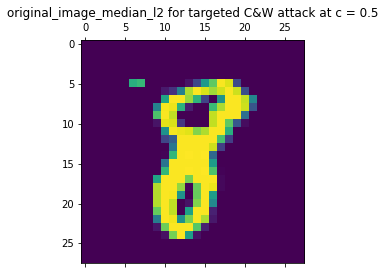

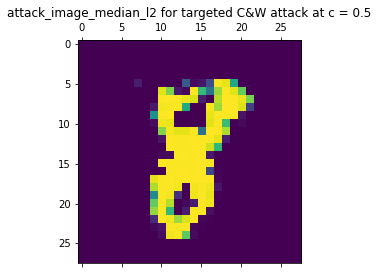

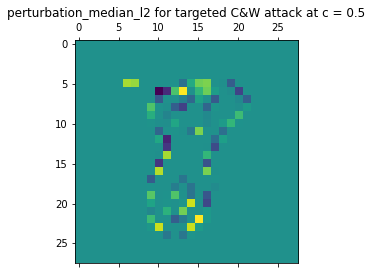

In [64]:
c_i,c = 3,0.5
print(f"===========MIN L2 ================")
l2_type = "min_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MAX L2 ================")
l2_type = "max_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

print(f"===========MEDIAN L2 ================")
l2_type = "median_l2"
viz_type = "original_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "attack_image_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

viz_type = "perturbation_"
viz_key = viz_type + l2_type
plt.matshow(l2_attack_metrics[c_i][viz_key])
plt.title(f"{viz_key} for targeted C&W attack at c = {c}")
plt.show()

# WRITE OBSERVATIONS FOR CARLINI AND FSGM VIZ